# Crossview localization from ground images and satellite image

## Import Libraries

In [1]:
from cvm_net import cvm_net_I, cvm_net_II
from input_data import InputData
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Define Network Configuration parameters

In [2]:
# --------------  configuration parameters  -------------- #
# the type of network to be used: "CVM-NET-I" or "CVM-NET-II"
network_type = 'CVM-NET-I'

batch_size = 5
is_training = False
loss_weight = 10.0
number_of_epoch = 1

learning_rate_val = 1e-5
keep_prob_val = 0.8
# -------------------------------------------------------- #

### CVMInference class loads a pretrained model, loads images and performs a forward pass over the set of images to extract descriptors

In [3]:
satellite_image_prefix = '../Data/CVUSA/imgs/aerial'
ground_image_prefix = '../Data/CVUSA/imgs/ground'
class CVMInference:
    def __init__(self):
        self.sat_x = tf.placeholder(tf.float32, [None, 512, 512, 3], name='sat_x')
        self.grd_x = tf.placeholder(tf.float32, [None, 224, 1232, 3], name='grd_x')
        self.keep_prob = tf.placeholder(tf.float32)

        # build model
        if network_type == 'CVM-NET-I':
            self.sat_global, self.grd_global = cvm_net_I(self.sat_x, self.grd_x, self.keep_prob, False)
        elif network_type == 'CVM-NET-II':
            self.sat_global, self.grd_global = cvm_net_II(self.sat_x, self.grd_x, self.keep_prob, False)
        else:
            print ('CONFIG ERROR: wrong network type, only CVM-NET-I and CVM-NET-II are valid')
        
        # run model
        print('CVMInference object created')
        self.config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
        
        self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=None)
    

    def load_images(self, is_ground = True, num_images = 5):
        if(is_ground):
            images = np.zeros([num_images, 224, 1232, 3], dtype = np.float32)
            for i in range(num_images):
                img = cv2.imread(ground_image_prefix + str(i) + '.jpg')
                img = img.astype(np.float32)
                # img -= 100.0
                img[:, :, 0] -= 103.939  # Blue
                img[:, :, 1] -= 116.779  # Green
                img[:, :, 2] -= 123.6  # Red
                images[i, :, :, :] = img
            return images
        else:
            images = np.zeros([num_images, 512, 512, 3], dtype=np.float32)
            for i in range(num_images):
                img = cv2.imread(satellite_image_prefix + str(i) + '.jpg')
                img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
                img = img.astype(np.float32)
                # img -= 100.0
                img[:, :, 0] -= 103.939  # Blue
                img[:, :, 1] -= 116.779  # Green
                img[:, :, 2] -= 123.6  # Red
                images[i, :, :, :] = img
            return images
    
    def load_images_raw(self, is_ground = True, num_images = 5):
        if(is_ground):
            images = np.zeros([num_images, 224, 1232, 3], dtype = np.uint8)
            for i in range(num_images):
                print(satellite_image_prefix + str(i) + '.jpg')
                img = cv2.imread(ground_image_prefix + str(i) + '.jpg')
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                images[i, :, :, :] = img
            return images
        else:
            images = np.zeros([num_images, 512, 512, 3], dtype=np.uint8)
            for i in range(num_images):
                img = cv2.imread(satellite_image_prefix + str(i) + '.jpg')
                img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                images[i, :, :, :] = img
            return images
            
            
    def preprocess(self, images, is_ground):
        num_images = images.shape[0]
        images = images.astype(np.float32)
        for image in images:
            # img -= 100.0
            img[:, :, 0] -= 103.939  # Blue
            img[:, :, 1] -= 116.779  # Green
            img[:, :, 2] -= 123.6  # Red

            image[:, :, 0] -= 103.939  # Blue
            image[:, :, 1] -= 116.779  # Green
            image[:, :, 2] -= 123.6  # Red
        return images
    
    def forward(self, images, is_ground = True):
        with tf.Session(config=self.config) as sess:
            sess.run(tf.global_variables_initializer())
            start_epoch = 1
            print('loading model...')
            load_model_path = '../Model/' + network_type + '/' + str(start_epoch - 1) + '/model.ckpt'
            self.saver.restore(sess, load_model_path)
            print("   Model loaded from: %s" % load_model_path)
            print('load model...FINISHED')
            
            # ---------------------- validation ----------------------
            print('validate...')
            print('   compute global descriptors')
            sat_zeros = np.zeros([images.shape[0],512,512, 3])
            grd_zeros = np.zeros([images.shape[0],224,1232, 3])
            
            if(is_ground):
                feed_dict = {self.sat_x: sat_zeros, self.grd_x: images, self.keep_prob: 1.0}
            else:
                feed_dict = {self.sat_x: images, self.grd_x: grd_zeros, self.keep_prob: 1.0}
                
            sat_global_val, grd_global_val = sess.run([self.sat_global, self.grd_global], feed_dict=feed_dict)

            if(is_ground):
                global_descriptor = grd_global_val
            else:
                global_descriptor = sat_global_val
                
            return global_descriptor


### Instance inference object

In [4]:
inference = CVMInference()

VGG16: trainable = False
VGG16: trainable = False
Siamese_FC: dim_reduction  trainable = False
CVMInference object created


### Extract decriptors from each satellite image (Only needs to be run the first time)

In [5]:
sat_descriptors = inference.forward(inference.load_images(is_ground = False), is_ground = False)
np.savez('sat_descriptors.npz', sat_descriptors)
print(sat_descriptors.shape)

loading model...
INFO:tensorflow:Restoring parameters from ../Model/CVM-NET-I/0/model.ckpt
   Model loaded from: ../Model/CVM-NET-I/0/model.ckpt
load model...FINISHED
validate...
   compute global descriptors
(5, 4096)


### Load Descriptors

In [13]:
sat_descriptors = np.load('sat_descriptors.npz')['arr_0']
print(sat_descriptors.shape)

(5, 4096)


### Load satellite and ground image

In [8]:
ground_images = inference.load_images_raw(is_ground = True)
satellite_images = inference.load_images_raw(is_ground = False)

../Data/CVUSA/imgs/aerial0.jpg
../Data/CVUSA/imgs/aerial1.jpg
../Data/CVUSA/imgs/aerial2.jpg
../Data/CVUSA/imgs/aerial3.jpg
../Data/CVUSA/imgs/aerial4.jpg


## Show images

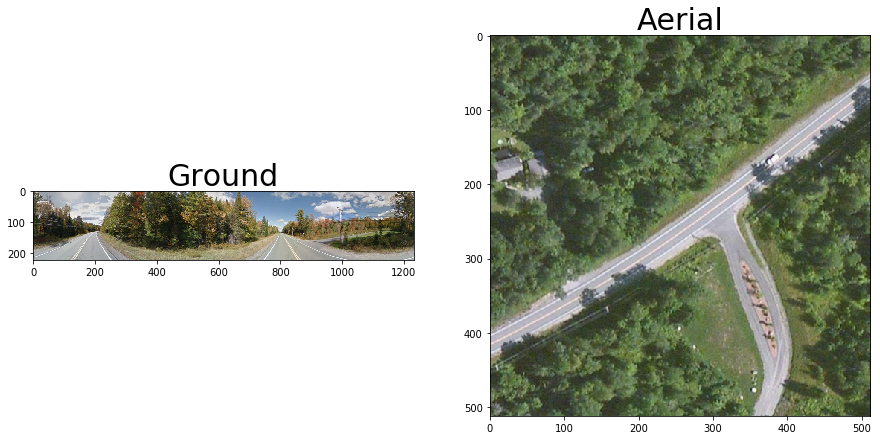

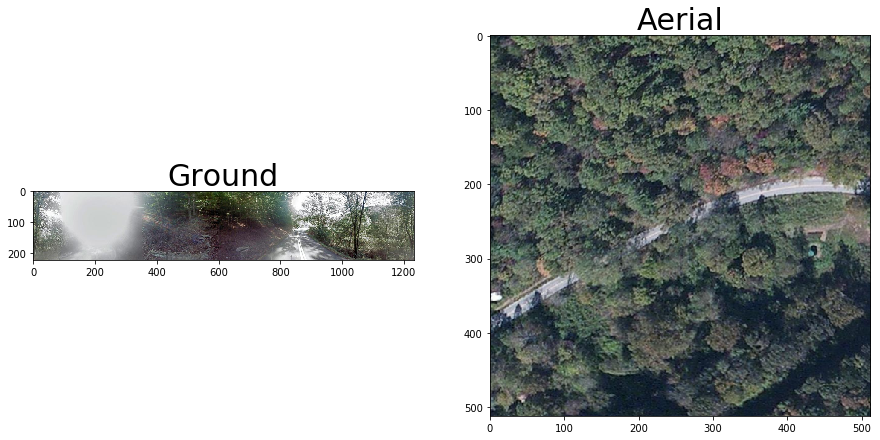

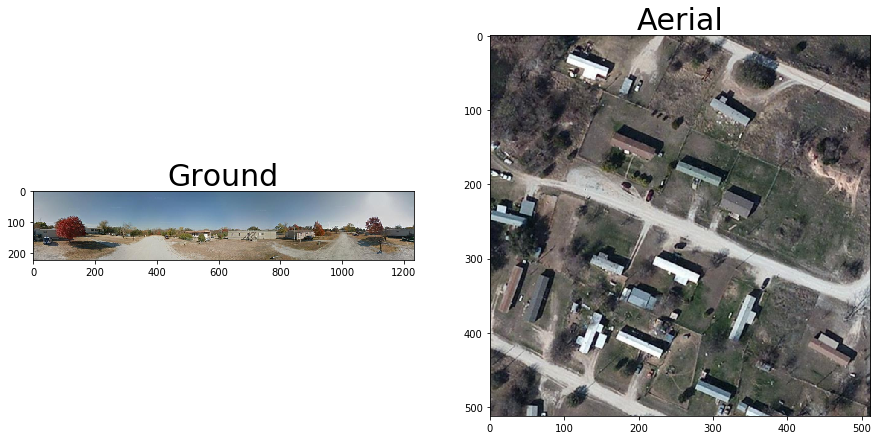

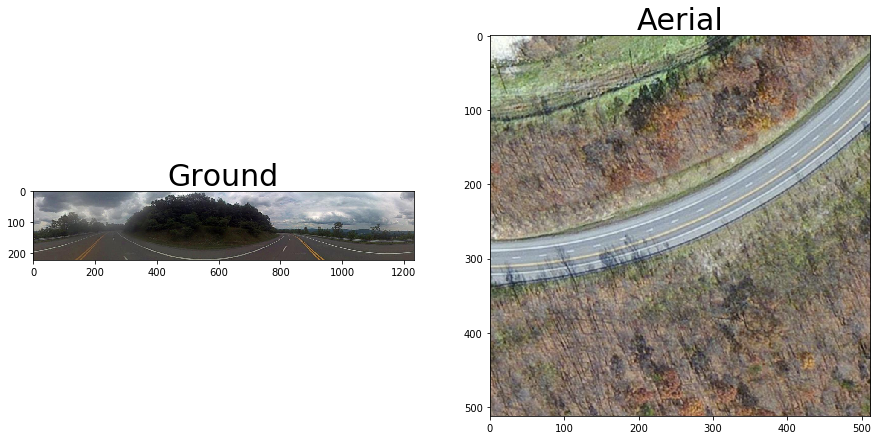

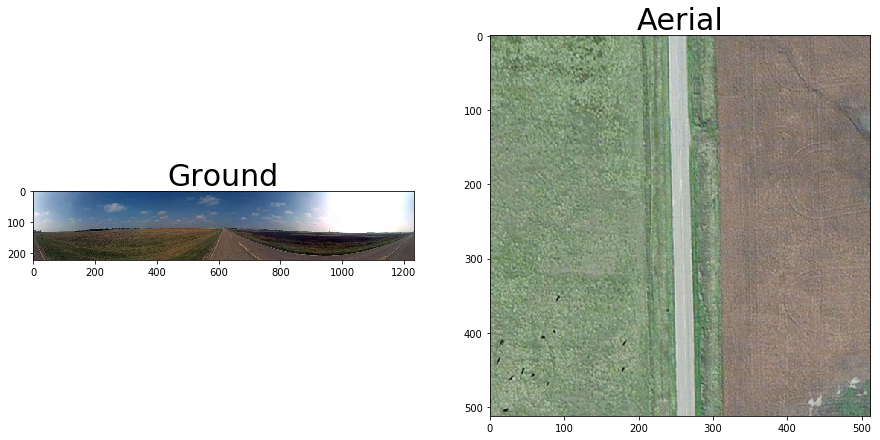

In [9]:
for i in range(5):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.imshow(ground_images[i])
    ax1.set_title('Ground', fontsize=30)
    ax2.imshow(satellite_images[i])
    ax2.set_title('Aerial', fontsize=30)
    plt.show()

### Compute descriptors of one of the ground images

In [10]:
ground_img_idx = 0
ground_descriptor = inference.forward(np.array([inference.load_images(is_ground = True)[ground_img_idx]]), is_ground = True)

loading model...
INFO:tensorflow:Restoring parameters from ../Model/CVM-NET-I/0/model.ckpt
   Model loaded from: ../Model/CVM-NET-I/0/model.ckpt
load model...FINISHED
validate...
   compute global descriptors


### Find the best matches for the ground image based on the descriptor

In [22]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) # only difference

In [25]:
euclidian_distances = []
i = 0
for sat_descriptor in sat_descriptors:
    dist = np.linalg.norm(sat_descriptor-ground_descriptor[0])
    euclidian_distances.append(1/dist)
indexes = np.arange(sat_descriptors.shape[0])
distances_dict = dict(zip(indexes.T, softmax(euclidian_distances)))

In [28]:
distances_dict

{0: 0.5297497579378808,
 1: 0.10759086683106703,
 2: 0.10675245839916034,
 3: 0.15131200668476238,
 4: 0.10459491014712943}

### Order Dictionary based on distances

In [35]:
sorted_d = sorted(distances_dict.items(), key = lambda x:-x[1])
sorted_d

[(0, 0.5297497579378808),
 (3, 0.15131200668476238),
 (1, 0.10759086683106703),
 (2, 0.10675245839916034),
 (4, 0.10459491014712943)]

In [45]:
print(sorted_d[1][0])

3


### Show Correspondences

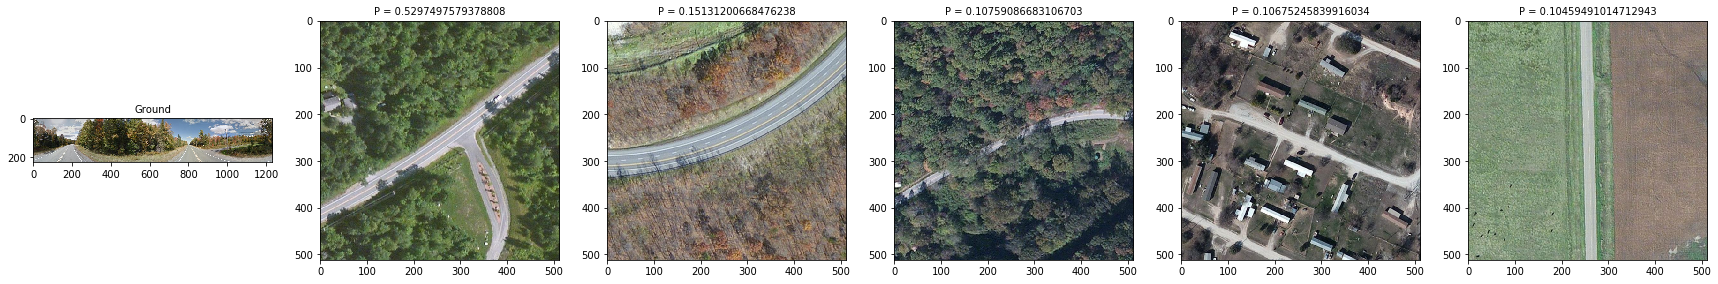

In [50]:
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(30,10))
ax1.imshow(ground_images[ground_img_idx])
ax1.set_title('Ground', fontsize=10)
ax2.imshow(satellite_images[sorted_d[0][0]])
ax2.set_title('P = ' + str(sorted_d[0][1]), fontsize=10)
ax3.imshow(satellite_images[sorted_d[1][0]])
ax3.set_title('P = ' + str(sorted_d[1][1]), fontsize=10)
ax4.imshow(satellite_images[sorted_d[2][0]])
ax4.set_title('P = ' + str(sorted_d[2][1]), fontsize=10)
ax5.imshow(satellite_images[sorted_d[3][0]])
ax5.set_title('P = ' + str(sorted_d[3][1]), fontsize=10)
ax6.imshow(satellite_images[sorted_d[4][0]])
ax6.set_title('P = ' + str(sorted_d[4][1]), fontsize=10)
plt.show()

# -----------------------------------End ------------------------------------

In [11]:
def validate(grd_descriptor, sat_descriptor):
    accuracy = 0.0
    data_amount = 0.0
    dist_array = 2 - 2 * np.matmul(sat_descriptor, np.transpose(grd_descriptor))
    top1_percent = int(dist_array.shape[0] * 0.01) + 1
    for i in range(dist_array.shape[0]):
        gt_dist = dist_array[i, i]
        prediction = np.sum(dist_array[:, i] < gt_dist)
        if prediction < top1_percent:
            accuracy += 1.0
        data_amount += 1.0
    accuracy /= data_amount

    return accuracy

In [12]:
def compute_loss(sat_global, grd_global, batch_hard_count=0):
    '''
    Compute the weighted soft-margin triplet loss
    :param sat_global: the satellite image global descriptor
    :param grd_global: the ground image global descriptor
    :param batch_hard_count: the number of top hard pairs within a batch. If 0, no in-batch hard negative mining
    :return: the loss
    '''
    with tf.name_scope('weighted_soft_margin_triplet_loss'):
        dist_array = 2 - 2 * tf.matmul(sat_global, grd_global, transpose_b=True)
        pos_dist = tf.diag_part(dist_array)
        if batch_hard_count == 0:
            pair_n = batch_size * (batch_size - 1.0)

            # ground to satellite
            triplet_dist_g2s = pos_dist - dist_array
            loss_g2s = tf.reduce_sum(tf.log(1 + tf.exp(triplet_dist_g2s * loss_weight))) / pair_n

            # satellite to ground
            triplet_dist_s2g = tf.expand_dims(pos_dist, 1) - dist_array
            loss_s2g = tf.reduce_sum(tf.log(1 + tf.exp(triplet_dist_s2g * loss_weight))) / pair_n

            loss = (loss_g2s + loss_s2g) / 2.0
        else:
            # ground to satellite
            triplet_dist_g2s = pos_dist - dist_array
            triplet_dist_g2s = tf.log(1 + tf.exp(triplet_dist_g2s * loss_weight))
            top_k_g2s, _ = tf.nn.top_k(tf.transpose(triplet_dist_g2s), batch_hard_count)
            loss_g2s = tf.reduce_mean(top_k_g2s)

            # satellite to ground
            triplet_dist_s2g = tf.expand_dims(pos_dist, 1) - dist_array
            triplet_dist_s2g = tf.log(1 + tf.exp(triplet_dist_s2g * loss_weight))
            top_k_s2g, _ = tf.nn.top_k(triplet_dist_s2g, batch_hard_count)
            loss_s2g = tf.reduce_mean(top_k_s2g)

            loss = (loss_g2s + loss_s2g) / 2.0

    return loss

In [13]:
def train(start_epoch=1):
    '''
    Train the network and do the test
    :param start_epoch: the epoch id start to train. The first epoch is 1.
    '''

    # import data
    input_data = InputData()


    # define placeholders
    sat_x = tf.placeholder(tf.float32, [None, 512, 512, 3], name='sat_x')
    grd_x = tf.placeholder(tf.float32, [None, 224, 1232, 3], name='grd_x')
    keep_prob = tf.placeholder(tf.float32)
    learning_rate = tf.placeholder(tf.float32)


    # build model
    if network_type == 'CVM-NET-I':
        sat_global, grd_global = cvm_net_I(sat_x, grd_x, keep_prob, is_training)
    elif network_type == 'CVM-NET-II':
        sat_global, grd_global = cvm_net_II(sat_x, grd_x, keep_prob, is_training)
    else:
        print ('CONFIG ERROR: wrong network type, only CVM-NET-I and CVM-NET-II are valid')


    # define loss
    loss = compute_loss(sat_global, grd_global, 0)


    # set training
    global_step = tf.Variable(0, trainable=False)
    with tf.device('/gpu:0'):
        with tf.name_scope('train'):
            train_step = tf.train.AdamOptimizer(learning_rate, 0.9, 0.999).minimize(loss, global_step=global_step)

    saver = tf.train.Saver(tf.global_variables(), max_to_keep=None)


    # run model
    print('run model...')
    config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
    #config.gpu_options.allow_growth = True
    #config.gpu_options.per_process_gpu_memory_fraction = 0.9
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())

        print('load model...')
        load_model_path = '../Model/' + network_type + '/' + str(start_epoch - 1) + '/model.ckpt'
        saver.restore(sess, load_model_path)
        print("   Model loaded from: %s" % load_model_path)
        print('load model...FINISHED')

        # Train
        for epoch in range(start_epoch, start_epoch + number_of_epoch):
            iter = 0
            if is_training:
                # train
                while True:
                    batch_sat, batch_grd = input_data.next_pair_batch(batch_size)
                    if batch_sat is None:
                        break

                    global_step_val = tf.train.global_step(sess, global_step)

                    feed_dict = {sat_x: batch_sat, grd_x: batch_grd,
                                 learning_rate: learning_rate_val, keep_prob: keep_prob_val}
                    if iter % 20 == 0:
                        _, loss_val = sess.run([train_step, loss], feed_dict=feed_dict)
                        print('global %d, epoch %d, iter %d: loss : %.4f' %
                              (global_step_val, epoch, iter, loss_val))
                    else:
                        sess.run(train_step, feed_dict=feed_dict)

                    iter += 1
            
            # ---------------------- validation ----------------------
            print('validate...')
            print('   compute global descriptors')
            input_data.reset_scan()
            sat_global_descriptor = np.zeros([input_data.get_test_dataset_size(), 4096])
            grd_global_descriptor = np.zeros([input_data.get_test_dataset_size(), 4096])
            val_i = 0
            while True:
                print('      progress %d' % val_i)
                batch_sat, batch_grd = input_data.next_batch_scan(batch_size)
                if batch_sat is None:
                    break
                feed_dict = {sat_x: batch_sat, grd_x: batch_grd, keep_prob: 1.0}
                sat_global_val, grd_global_val = \
                    sess.run([sat_global, grd_global], feed_dict=feed_dict)

                sat_global_descriptor[val_i: val_i + sat_global_val.shape[0], :] = sat_global_val
                grd_global_descriptor[val_i: val_i + grd_global_val.shape[0], :] = grd_global_val
                val_i += sat_global_val.shape[0]

            print('   compute accuracy')
            val_accuracy = validate(grd_global_descriptor, sat_global_descriptor)
            with open('../Result/' + str(network_type) + '_accuracy.txt', 'a') as file:
                file.write(str(epoch) + ' ' + str(iter) + ' : ' + str(val_accuracy) + '\n')
            print('   %d: accuracy = %.1f%%' % (epoch, val_accuracy*100.0))

            model_dir = '../Model/' + network_type + '/' + str(epoch) + '/'
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            #save_path = saver.save(sess, model_dir + 'model.ckpt')
            print("Model saved in file: %s" % save_path)
            return sat_global_descriptor, grd_global_descriptor
            # ---------------------------------------------------------

In [14]:
sat_global_descriptor, grd_global_descriptor = train()

InputData::__init__: load ../Data/CVUSA/data.csv
InputData::__init__: load ../Data/CVUSA/data.csv  data_size = 5
InputData::__init__: load ../Data/CVUSA/data.csv
InputData::__init__: load ../Data/CVUSA/data.csv  data_size = 5
VGG16: trainable = False
VGG16: trainable = False
Siamese_FC: dim_reduction  trainable = False
run model...
load model...
INFO:tensorflow:Restoring parameters from ../Model/CVM-NET-I/0/model.ckpt
   Model loaded from: ../Model/CVM-NET-I/0/model.ckpt
load model...FINISHED
validate...
   compute global descriptors
      progress 0
      progress 5
   compute accuracy
   1: accuracy = 100.0%
INFO:tensorflow:../Model/CVM-NET-I/1/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ../Model/CVM-NET-I/1/model.ckpt


In [16]:
print(sat_global_descriptor.shape)

(5, 4096)


In [17]:
print(grd_global_descriptor.shape)

(5, 4096)


In [30]:
np.linalg.norm(sat_global_descriptor[0]-grd_global_descriptor[3])

0.9917549762354467

In [27]:
a_min_b = sat_global_descriptor-grd_global_descriptor
np.sqrt(np.einsum('ij,ij->i', a_min_b, a_min_b))

array([0.45026993, 0.43935136, 0.51793234, 0.66502767, 0.43272668])